<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [65]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

λ_hub = 0.25
λ_tip = 12.0
dλ = 0.25
n = int( ( λ_tip - λ_hub ) / dλ + 1 )
λ_set = np.linspace( λ_hub, λ_tip, n )

a_vec = np.zeros_like( λ_set )
ap_vec = np.zeros_like( λ_set )
ϕ_vec = np.zeros_like( λ_set )
Zc_vec = np.zeros_like( λ_set )
CP_vec = np.zeros_like( λ_set )

## Glauert optimal distribution

C_P = 0.5871


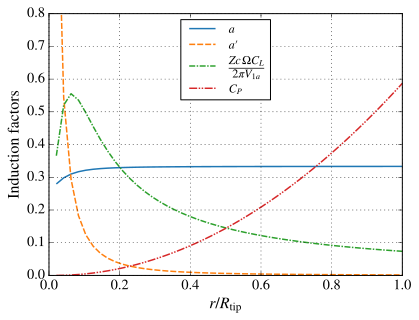

In [70]:
def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( y2, y1, λ_tip ):
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

for i, λ in enumerate( λ_set ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    Zc  = 4.0 * ap * λ**2 / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    a_vec[i] = a
    ap_vec[i] = ap
    ϕ_vec[i] = ϕ
    Zc_vec[i] = Zc

    if i > 0:
        CP += Integral_f( 1 - 3*a_vec[i], 1 - 3*a_vec[i-1], λ_tip )
    else:
        CP = 0.0

    CP_vec[i] = CP

x_vec = λ_set / λ_tip

mpl.plot( x_vec, a_vec,  label = r"$a$" )
mpl.plot( x_vec, ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, EE_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {CP_vec[-1]:.4f}" )

In [ ]:
df = pd.DataFrame( { r"$\lambda$": np.round(λ_vec,decimals=2),
                     r"$a$": np.round(a_vec,decimals=5),
                     r"$a'$": np.round(ap_vec,decimals=5),
                     r"$\phi$": np.round(ϕ_vec, decimals=2)*rad2deg,
                     r"$C_P$": np.round(CP_vec,decimals=5),
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": np.round(EE_vec, decimals=5)
                    } )

print( df.to_latex(index=False,
                formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format,"{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
))
df

## Computing the turbine blade

In [ ]:
V1a = 2.5
Ω = 24.0 * np.pi / 30.0
Z = 3

α  = 5 * deg2rad
CL = 1.00
CD = 0.05
γ = np.arctan( CD / CL )

EE_factor = 2.0 * np.pi * V1a / ( Z * Ω * CL )

θ_vec = []
r_vec = []
c_vec = []
CP2_vec = []

for i, ( λ, a, ap, ϕ, EE ) in enumerate( zip( λ_vec, a_vec, ap_vec, ϕ_vec, EE_vec ) ):

    θ = ϕ - α
    r = λ * V1a / Ω
    c = EE * EE_factor
    η = np.sin( ϕ - γ ) / np.sin( ϕ )

    if i > 0:
        dλ = λ_vec[i] - λ_vec[i-1]
        CPm = 0.5 * ( CP_vec[i] + CP_vec[i-1] )
        CP2 = CP2_vec[i-1] + η * CPm * dλ
    else:
        CP2 = 0.0

    CP2_vec.append( CP2 )

    θ_vec.append( θ )
    r_vec.append( r )
    c_vec.append( c )

ax1 = mpl.gca()
ax1.plot( r_vec, c_vec, mut.linecolors[0], label="blade chord, $c$" )
ax1.set_ylabel( "Blade chord, [m]", color=mut.linecolors[0] )
ax1.set_xlabel( r"radius, $r$ [m]")
ax2 = mpl.gca().twinx()
ax2.plot( r_vec, np.array( θ_vec ) * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( "Pitch angle, [$^\circ$]", color=mut.linecolors[1] )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineDesign.pdf" )

print( f"C_P = {CP2_vec[-1]:.4f}" )